This notebook, generates all the figures included in the paper *Long-term losses in surface water area in the Colorado River Basin*.

In [4]:
import pandas as pd
import rasterio
import numpy as np 
import matplotlib.pyplot as plt 
import geopandas as gpd
import matplotlib.colors as mcolors
from matplotlib.patches import Wedge, Patch
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

In [2]:
## Load all data paths needed 
crb_data = pd.read_csv('../Data/analysis-data/huc4_zonal_stats.csv') #zonal statistics for each huc4
crb_huc4 = gpd.read_file('../Data/processed-data/shapefiles/CRB_HUC4.shp') #huc4 shapefile
crb_rivers = gpd.read_file('../Data/processed-data/shapefiles/CRB_major_rivers.shp') #major river shapefile
lake_mead = gpd.read_file('../Data/processed-data/shapefiles/Lake_Mead.shp') #lake mead shapefile 
lake_powell = gpd.read_file('../Data/processed-data/shapefiles/Lake_Powell.shp') #lake powell shapefile
urban_cities = gpd.read_file('../Data/processed-data/shapefiles/CRB_urban_cities.shp') #major urban hubs in the CRB
crb_states = gpd.read_file('../Data/processed-data/shapefiles/CRB_states.shp') #states that intersect the CRB 

#Color Labels 
color_total_water = '#440154'
color_perm = '#297a8e' # pixel class = 3
color_seasonal = '#34E4EA' # pixel class = 2
color_nowater = '#e2e418' #pixel class = 1

#list of huc4 id's
huc4_list = list(np.unique(crb_data.huc4))

#functions needed for future plots 
def draw_pie(ax, sizes, x, y, color_spec):
    # Function to draw pie charts
    startangle = 90
    for size, color in zip(sizes, color_spec):
        angle = size * 360
        wedge = Wedge((x, y), 0.5, startangle, startangle + angle, facecolor=color)
        wedge.set_zorder(5)
        ax.add_patch(wedge)
        startangle += angle


In [40]:
crb_data.columns

Index(['year', 'huc4', 'huc_name', 'count_total', 'count_permanent',
       'count_seasonal', 'count_nowater', 'count_no_obs', 'count_huc',
       'area_total_water', 'area_permanent', 'area_seasonal', 'area_nowater'],
      dtype='object')

## Colorado River Basin Figure with permanent and seasonal water fractions

In [4]:
## Calculate the average permanent and seasonal water for each HUC 
avg_data = {
    'huc4': [],              #huc4 id's 
    'perm_water_avg': [],    #save permanent water area average from 1984 to 2021 
    'seasonal_water_avg': [] #save seasonal water area average from 1984 to 2021
}

for huc in huc4_list: 
    data = crb_data[crb_data['huc4']==huc]

    perm_water_avg = data['area_permanent'].mean()
    seasonal_water_avg = data['area_seasonal'].mean()

    avg_data['huc4'].append(str(huc))
    avg_data['perm_water_avg'].append(round(perm_water_avg,2))
    avg_data['seasonal_water_avg'].append(round(seasonal_water_avg,2))

avg_data_df = pd.DataFrame(avg_data)

#merge data with shapefile of the crb 
crb_huc4_merge = crb_huc4.merge(avg_data_df, on = 'huc4')

#define the colors for upper and lower basin hucs
upper_color = '#bed7dd'
lower_color = '#aee2c9'

#shade upper and lower colorado river sub regions 
upper_hucs = crb_huc4_merge[crb_huc4_merge['huc4'].astype(int).between(1401, 1408)]
lower_hucs = crb_huc4_merge[crb_huc4_merge['huc4'].astype(int).between(1501,1507)]

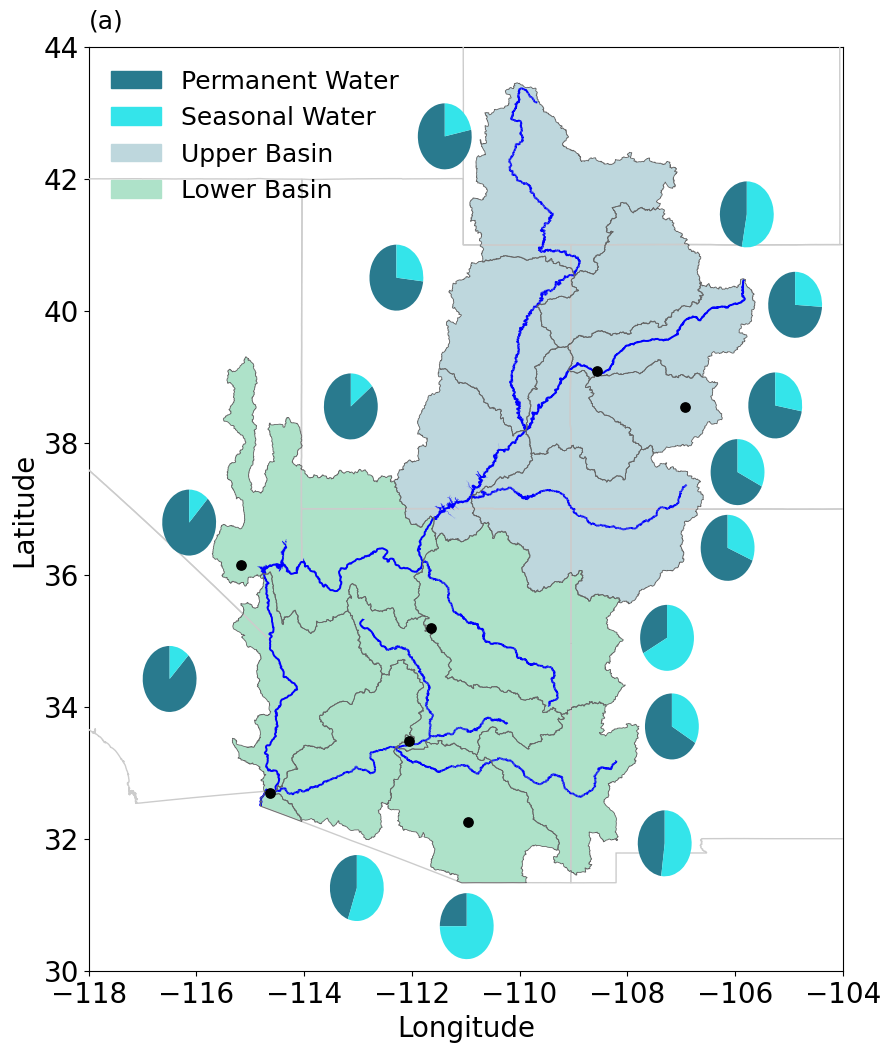

In [54]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(12, 12))

crb_rivers.plot(ax = ax, linewidth = 1.4, color = 'blue', zorder = 6)
lake_mead.plot(ax = ax, color = 'blue', zorder =7)
lake_powell.plot(ax = ax, color = 'blue', zorder = 7)
urban_cities.plot(ax = ax, color = 'black', zorder = 7, label = 'Major cities', marker = 'o', markersize = 45)

crb_huc4_merge.boundary.plot(ax = ax, linewidth = 0.6, edgecolor = '0.4', zorder = 6)
crb_states.boundary.plot(ax=ax, linewidth=1, edgecolor = '0.8', zorder = 5)
upper_hucs.plot(ax=ax, color=upper_color,zorder = 4, label = 'Upper CRB') #zorder ensures the ploting
lower_hucs.plot(ax=ax, color=lower_color, zorder =4, label = 'Lower CRB')

plt.xlim(-118, -104)
plt.ylim(30, 44)

# Label HUCs and add pie charts
for idx, row in crb_huc4_merge.iterrows():
    sizes = [row['perm_water_avg'], row['seasonal_water_avg']]
    sizes = sizes / np.sum(sizes)  # Normalize to sum to 
    centroid_x = row.geometry.centroid.x
    centroid_y = row.geometry.centroid.y

    huc_label = int(row['huc4'])

    if huc_label == 1401:
        offset_x, offset_y = (2.3, 0.5)
    elif huc_label == 1408:
        offset_x, offset_y = (2.5, -0.4)
    elif huc_label == 1502:
        offset_x, offset_y = (2.8, -0.2)
    elif huc_label == 1504:
        offset_x, offset_y = (1.8, -1.0)
    elif huc_label == 1405:
        offset_x, offset_y = (2.2, 1.0)
    elif huc_label == 1402:
        offset_x, offset_y = (2.2, 0.0)
    elif huc_label == 1403: 
        offset_x, offset_y = (3.0,-0.8)
    elif huc_label in [1404, 1406, 1407]: 
        offset_x, offset_y = (-2.0, 0.8)
    elif huc_label in [1501, 1503]:
        offset_x, offset_y = (-2.4, 0.1)
    elif huc_label == 1506: 
        offset_x, offset_y = (4.2, -0.6)
    elif huc_label == 1507: 
        offset_x, offset_y = (0.0, -2.0)
    else: 
        offset_x, offset_y = (0.0, -1.7)

    # Apply offsets to position the pie chart
    chart_x = centroid_x + offset_x
    chart_y = centroid_y + offset_y

    # Draw pie chart
    #draw_pie_alt(ax, sizes, offset_x, offset_y, [color_perm, color_seasonal])
    
    # Add arrow
    #arrow = ConnectionPatch((centroid_x, centroid_y), (offset_x, offset_y),
     #                        "data", "data",
      #                       arrowstyle="->", color="black", lw=1.5)
    #ax.add_artist(arrow)
    draw_pie(ax, sizes, chart_x, chart_y, [color_perm, color_seasonal])

# Add legend for permanent and seasonal water
legend_labels = ['Permanent Water', 'Seasonal Water', 'Upper Basin', 'Lower Basin']
colors = [color_perm, color_seasonal, upper_color, lower_color]
patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]

plt.legend(handles = patches, loc = 'upper left', frameon = False, fontsize = 18)
ax.text(0, 1.02, '(a)', transform=ax.transAxes, fontsize = 18)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig('../Results/figures/Basin-figure1a.jpg', bbox_inches ='tight', dpi = 600)
plt.show()

## Lake Mead and section of Green River through the years 1984, 2002, and 2021

In [3]:
## load data for each raster 
raster_path_84 = "../Data/processed-data/yearly_water_history-CRB/1984_CRB.tif"
raster_path_02 = "../Data/processed-data/yearly_water_history-CRB/2002_CRB.tif"
raster_path_21 = "../Data/processed-data/yearly_water_history-CRB/2021_CRB.tif"

# Define the color for each class
class_colors = {
    1: color_nowater, 
    2: color_seasonal, 
    3: color_perm, 
    4: 'white'
}

#open the raster files might take some time to load 
with rasterio.open(raster_path_84) as src:
    raster_data_84 = src.read(1)  # the data is in the first band
    # Create a masked array where the mask is applied to class values
    masked_data_84 = np.ma.masked_array(raster_data_84, ~np.isin(raster_data_84, list(class_colors.keys())))

with rasterio.open(raster_path_02) as src:
    raster_data_02 = src.read(1)  # the data is in the first band
    # Create a masked array where the mask is applied to class values
    masked_data_02 = np.ma.masked_array(raster_data_02, ~np.isin(raster_data_02, list(class_colors.keys())))

with rasterio.open(raster_path_21) as src:
    raster_data_21 = src.read(1)  # the data is in the first band
    # Create a masked array where the mask is applied to class values
    masked_data_21 = np.ma.masked_array(raster_data_21, ~np.isin(raster_data_21, list(class_colors.keys())))

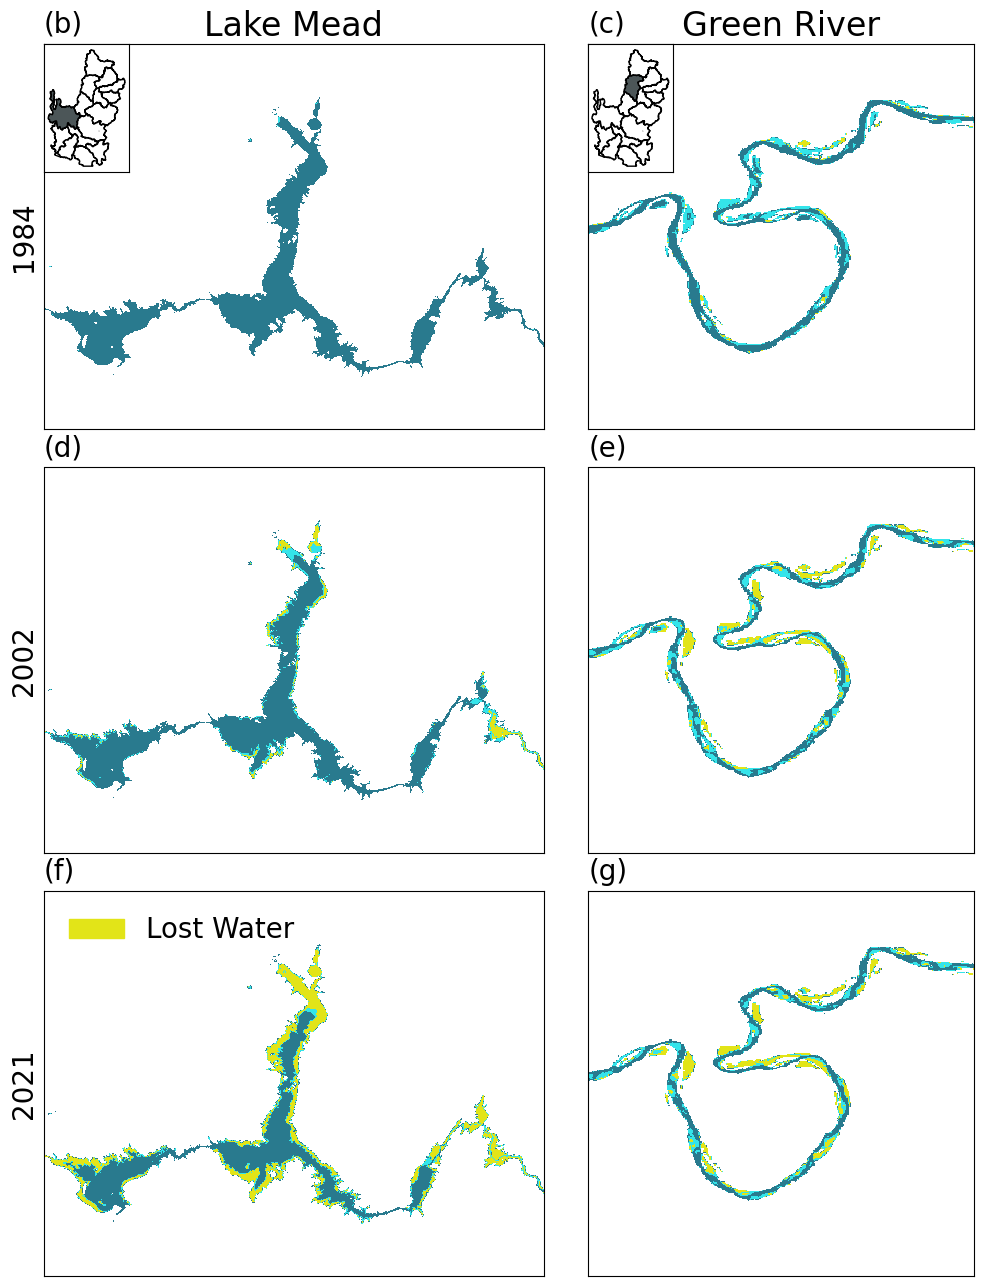

In [ ]:
#get the subset of the masked data for the location I want
lake_mead84 = masked_data_84[27500:29900, 3300:7300]
lake_mead02 = masked_data_02[27500:29900, 3300:7300]
lake_mead21 = masked_data_21[27500:29900, 3300:7300]

green_river84 = masked_data_84[12530:12880, 24550:25000]
green_river02 = masked_data_02[12530:12880, 24550:25000]
green_river21 = masked_data_21[12530:12880, 24550:25000]

legend_patches = [
    Patch(color=color_nowater, label='Lost Water')
]

# Add a column to CRB_HUC4_merge for colors: blue for '1501', white for others
crb_huc4_merge['color'] = crb_huc4_merge['huc4'].apply(lambda x: '#4C5658' if x == '1501' else 'white')

cmap = ListedColormap([color_nowater, color_seasonal, color_perm, 'white'])
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(3,2, figsize = (12,16), gridspec_kw={'width_ratios': [1.3, 1]})

ax[0,0].imshow(lake_mead84, cmap=cmap)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('Lake Mead')
ax[0,0].set_ylabel('1984')
ax[0,0].text(0, 1.03, '(b)', transform=ax[0,0].transAxes)
ax[0,0].set_aspect('equal', adjustable="datalim")

# Create an inset axis for the HUC shapefile specific to Lake Mead
inset_ax = fig.add_axes([0.1209, 0.80, 0.08, 0.08])
crb_huc4_merge.plot(ax=inset_ax, edgecolor = 'black', color = crb_huc4_merge['color'])
inset_ax.set_xticks([])
inset_ax.set_yticks([])

ax[0,1].imshow(green_river84, cmap=cmap)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('Green River')
ax[0,1].text(0, 1.03, '(c)', transform=ax[0,1].transAxes)
ax[0,1].set_aspect('equal', adjustable="datalim")

crb_huc4_merge['color'] = crb_huc4_merge['huc4'].apply(lambda x: '#4C5658' if x == '1406' else 'white')
# Create an inset axis for the HUC shapefile specific to the section of Green River
inset_ax2 = fig.add_axes([0.574, 0.8, 0.08, 0.08])
crb_huc4_merge.plot(ax=inset_ax2, edgecolor = 'black', color = crb_huc4_merge['color'])
inset_ax2.set_xticks([])
inset_ax2.set_yticks([])

ax[1,0].imshow(lake_mead02, cmap=cmap)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_ylabel('2002')
ax[1,0].text(0, 1.03, '(d)', transform=ax[1,0].transAxes)
ax[1,0].set_aspect('equal', adjustable="datalim")

ax[1,1].imshow(green_river02, cmap=cmap)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].text(0, 1.03, '(e)', transform=ax[1,1].transAxes)
ax[1,1].set_aspect('equal', adjustable="datalim")

ax[2,0].imshow(lake_mead21, cmap=cmap)
ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_ylabel('2021')
ax[2,0].text(0, 1.03, '(f)', transform=ax[2,0].transAxes)
ax[2,0].set_aspect('equal', adjustable="datalim")
ax[2,0].legend(handles=legend_patches, loc='upper left', frameon=False, fontsize = 20)

ax[2,1].imshow(green_river21, cmap=cmap)
ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].text(0, 1.03, '(g)', transform=ax[2,1].transAxes)
ax[2,1].set_aspect('equal', adjustable="datalim")


plt.subplots_adjust(wspace=0.1, hspace=0.1) 
plt.savefig('../Results/figures/Basin-figure1b-g.jpg', bbox_inches ='tight', dpi = 600)

## Time series of inundated area classifications 
We grab the sum of the hucs in the Basin to calculate time series of seasonal, permanent, no water, and totla water (sum of seasonal and permanent). 

In [ ]:
#list of upper and lower HUCs
upper_hucs = huc4_list[0:8]
lower_hucs = huc4_list[8:15]

#subset the CRB dataset into upper and lower 
upper_df = crb_data[crb_data["huc4"].isin(upper_hucs)]
lower_df = crb_data[crb_data["huc4"].isin(lower_hucs)]

#sum of the CRB 
CRB_sum = crb_data.groupby('year')[['area_total_water', 'area_permanent', 'area_seasonal', 'area_nowater']].sum().reset_index()
#sum of the UCRB 
UCRB_sum = upper_df.groupby('year')[['area_total_water', 'area_permanent', 'area_seasonal', 'area_nowater']].sum().reset_index()
#sum of the LCRB
LCRB_sum = lower_df.groupby('year')[['area_total_water', 'area_permanent', 'area_seasonal', 'area_nowater']].sum().reset_index()

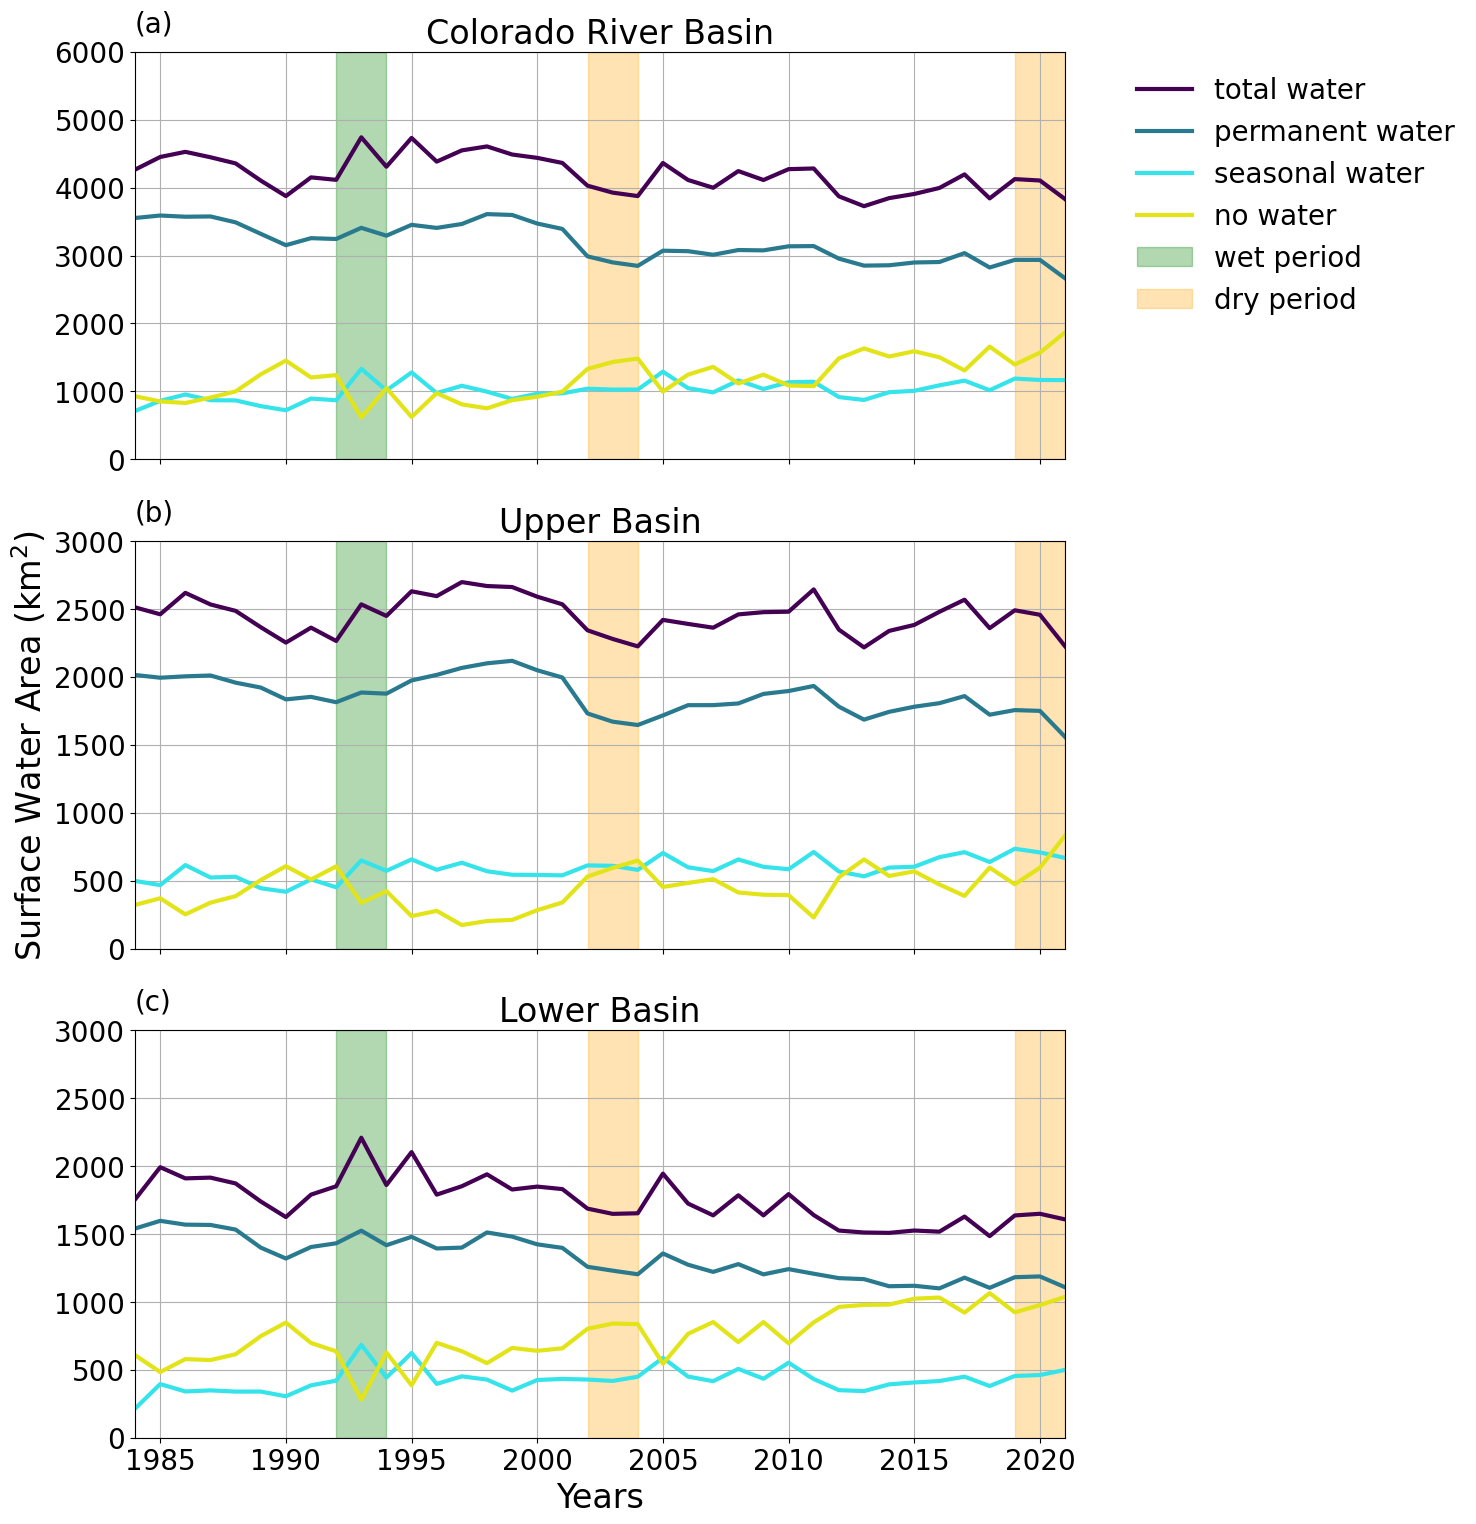

In [19]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(3, figsize = (12,18))
ax[0].plot(CRB_sum['year'], CRB_sum['area_total_water'], color=color_total_water, label = 'total water', linewidth = 3)
ax[0].plot(CRB_sum['year'], CRB_sum['area_permanent'], color=color_perm, label = 'permanent water', linewidth = 3)
ax[0].plot(CRB_sum['year'], CRB_sum['area_seasonal'], color=color_seasonal, label = 'seasonal water', linewidth = 3)
ax[0].plot(CRB_sum['year'], CRB_sum['area_nowater'], color=color_nowater, label = 'no water', linewidth = 3)
ax[0].axvspan(1992, 1994, color = 'green', alpha = 0.3, label = "wet period")
ax[0].axvspan(2002, 2004, color = 'orange', alpha = 0.3, label = "dry period")
ax[0].axvspan(2019, 2021, color = 'orange', alpha = 0.3)
ax[0].set_xticklabels([])
ax[0].set_ylim(0,6000)
ax[0].set_xlim(1984, 2021)
ax[0].grid(True)
ax[0].set_title("Colorado River Basin")
ax[0].legend(bbox_to_anchor=(1.05, 1), frameon=False)
ax[0].text(0, 1.05, '(a)', transform=ax[0].transAxes)


ax[1].plot(UCRB_sum['year'], UCRB_sum['area_total_water'], color=color_total_water, label = 'total', linewidth = 3)
ax[1].plot(UCRB_sum['year'], UCRB_sum['area_permanent'], color=color_perm, label = 'permanent', linewidth = 3)
ax[1].plot(UCRB_sum['year'], UCRB_sum['area_seasonal'], color=color_seasonal, label = 'seasonal', linewidth = 3)
ax[1].plot(UCRB_sum['year'], UCRB_sum['area_nowater'], color=color_nowater, label = 'no water', linewidth = 3)
ax[1].axvspan(1992, 1994, color = 'green', alpha = 0.3)
ax[1].axvspan(2002, 2004, color = 'orange', alpha = 0.3)
ax[1].axvspan(2019, 2021, color = 'orange', alpha = 0.3)
ax[1].set_xticklabels([])
ax[1].set_ylim(0,3000)
ax[1].set_xlim(1984, 2021)
ax[1].grid(True)
ax[1].set_title("Upper Basin")
ax[1].set_ylabel('Surface Water Area (km$^2$)', fontsize = 24)
ax[1].text(0, 1.05, '(b)', transform=ax[1].transAxes)

ax[2].plot(LCRB_sum['year'], LCRB_sum['area_total_water'], color=color_total_water, label = 'total', linewidth = 3)
ax[2].plot(LCRB_sum['year'], LCRB_sum['area_permanent'], color=color_perm, label = 'permanent', linewidth = 3)
ax[2].plot(LCRB_sum['year'], LCRB_sum['area_seasonal'], color=color_seasonal, label = 'seasonal', linewidth = 3)
ax[2].plot(LCRB_sum['year'], LCRB_sum['area_nowater'], color=color_nowater, label = 'no water', linewidth = 3)
ax[2].axvspan(1992, 1994, color = 'green', alpha = 0.3)
ax[2].axvspan(2002, 2004, color = 'orange', alpha = 0.3)
ax[2].axvspan(2019, 2021, color = 'orange', alpha = 0.3)
ax[2].set_ylim(0,3000)
ax[2].set_xlim(1984, 2021)
ax[2].grid(True)
ax[2].set_title("Lower Basin")
ax[2].set_xlabel("Years", fontsize = 24)
ax[2].text(0, 1.05, '(c)', transform=ax[2].transAxes)

plt.savefig('../Results/figures/timeseries-figure4.jpg', bbox_inches ='tight', dpi = 600)


## Net change figure 

## Percent change of total, permanent, and seasonal inundated water areas 
from wet period 1992 - 1994 to end of the study period 2019 - 2021 

In [9]:
transitions_92_19 = pd.read_csv('../Data/analysis-data/water_type_transitions_92_19.csv')
transitions_02_19 = pd.read_csv('../Data/analysis-data/water_type_transitions_02_19.csv')

#make the huc id's a string (originally integer)
transitions_92_19['huc4'] = transitions_92_19['huc4'].map(str)
transitions_02_19['huc4'] = transitions_02_19['huc4'].map(str)
#merge this dataset with the shapefile using the huc4 id's 
huc4_transitions_92_19 = crb_huc4.merge(transitions_92_19, on = 'huc4')
huc4_transitions_02_19 =crb_huc4.merge(transitions_02_19, on = 'huc4')

In [32]:
transitions_02_19.columns

Index(['huc4', 'permanent_area_period1', 'seasonal_area_period1',
       'nowater_area_period1', 'permanent_area_period2',
       'seasonal_area_period2', 'nowater_area_period2',
       'perm_nowater_trans_area', 'perm_seasonal_trans_area',
       'seasonal_nowater_trans_area', 'seasonal_perm_trans_area',
       'nowater_seasonal_trans_area', 'nowater_perm_trans_area',
       'dry_transition_area', 'wet_transition_area', 'total_area_period1',
       'total_area_period2', 'perm_diff_02_19', 'season_diff_02_19',
       'total_diff_02_19', 'perm_nowater_perc', 'perm_season_perc',
       'seasonal_nowater_perc', 'seasonal_perm_perc', 'nowater_season_perc',
       'nowater_perm_perc', 'dry_trans_area_perc', 'wet_trans_area_perc'],
      dtype='object')

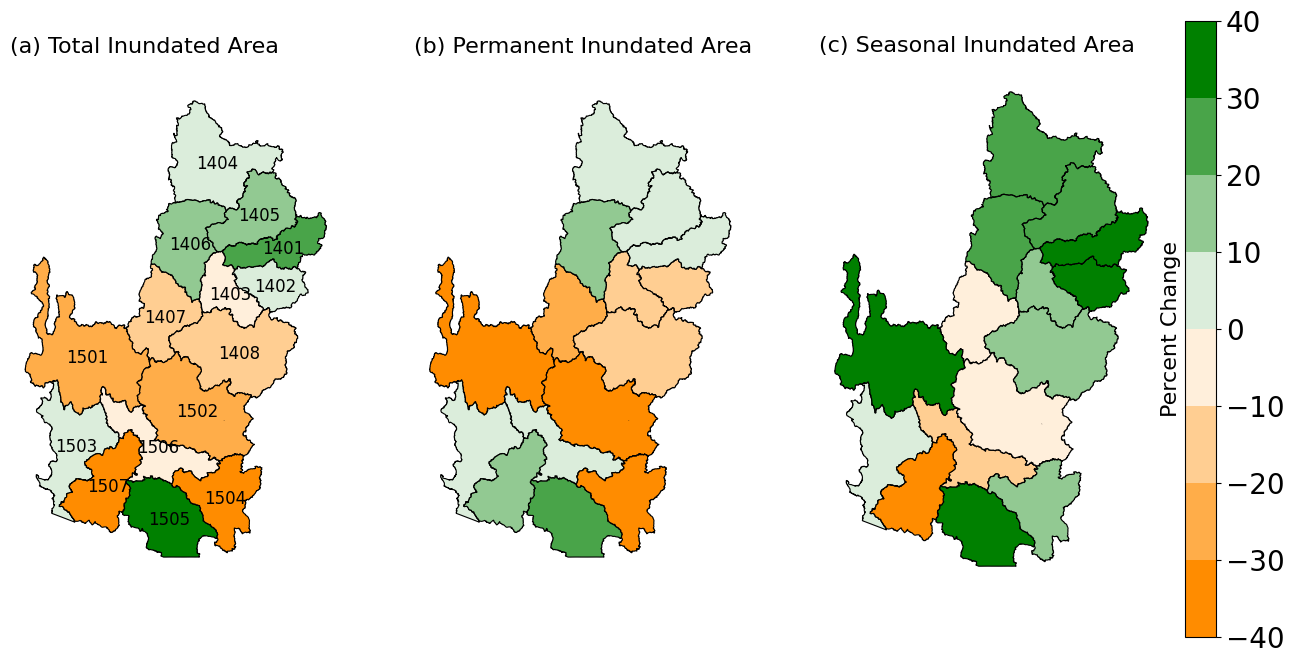

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1, 1.3]})
plt.rcParams.update({'font.size': 20})
cmap_diff = mcolors.LinearSegmentedColormap.from_list('custom_wet', [(0, 'darkorange'), (0.5, 'white'),  (1, 'green')], N = 8)
#limit the color bar 
vmin = -40
vmax = 40
# Plot on the first map
huc4_transitions_92_19.plot(ax=ax[0], column='total_diff_92_19', legend=False, cmap=cmap_diff, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[0].axis('off')  # Turn off axis
ax[0].text(0, 1.05, '(a) Total Inundated Area', transform=ax[0].transAxes, fontsize = 16)

huc4_transitions_92_19.plot(ax=ax[1], column='perm_diff_92_19', legend=False, cmap=cmap_diff, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[1].axis('off')  # Turn off axis
ax[0].text(0, 1.05, '(b) Permanent Inundated Area', transform=ax[1].transAxes, fontsize = 16)

huc4_transitions_92_19.plot(ax=ax[2], column='season_diff_92_19', legend=True, cmap=cmap_diff, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[2].axis('off')  # Turn off axis
ax[2].text(0, 1.03, '(c) Seasonal Inundated Area', transform=ax[2].transAxes, fontsize = 16)
ax[2].text(1.05,0.5, 'Percent Change',horizontalalignment='right',
        verticalalignment='center', rotation='vertical', transform=ax[2].transAxes, fontsize = 16)

for idx, row in huc4_transitions_92_19.iterrows():
    ax[0].text(row.geometry.centroid.x - 0.6, row.geometry.centroid.y - 0.2, 
               row["huc4"], fontsize=12, color='black')

plt.savefig('../Results/figures/percent_change_water_type-figure2.jpg', bbox_inches ='tight', dpi = 600)

## Dry and Wet Transition percentages 
This is the dry and wet transitions for wet period and end of study period. 

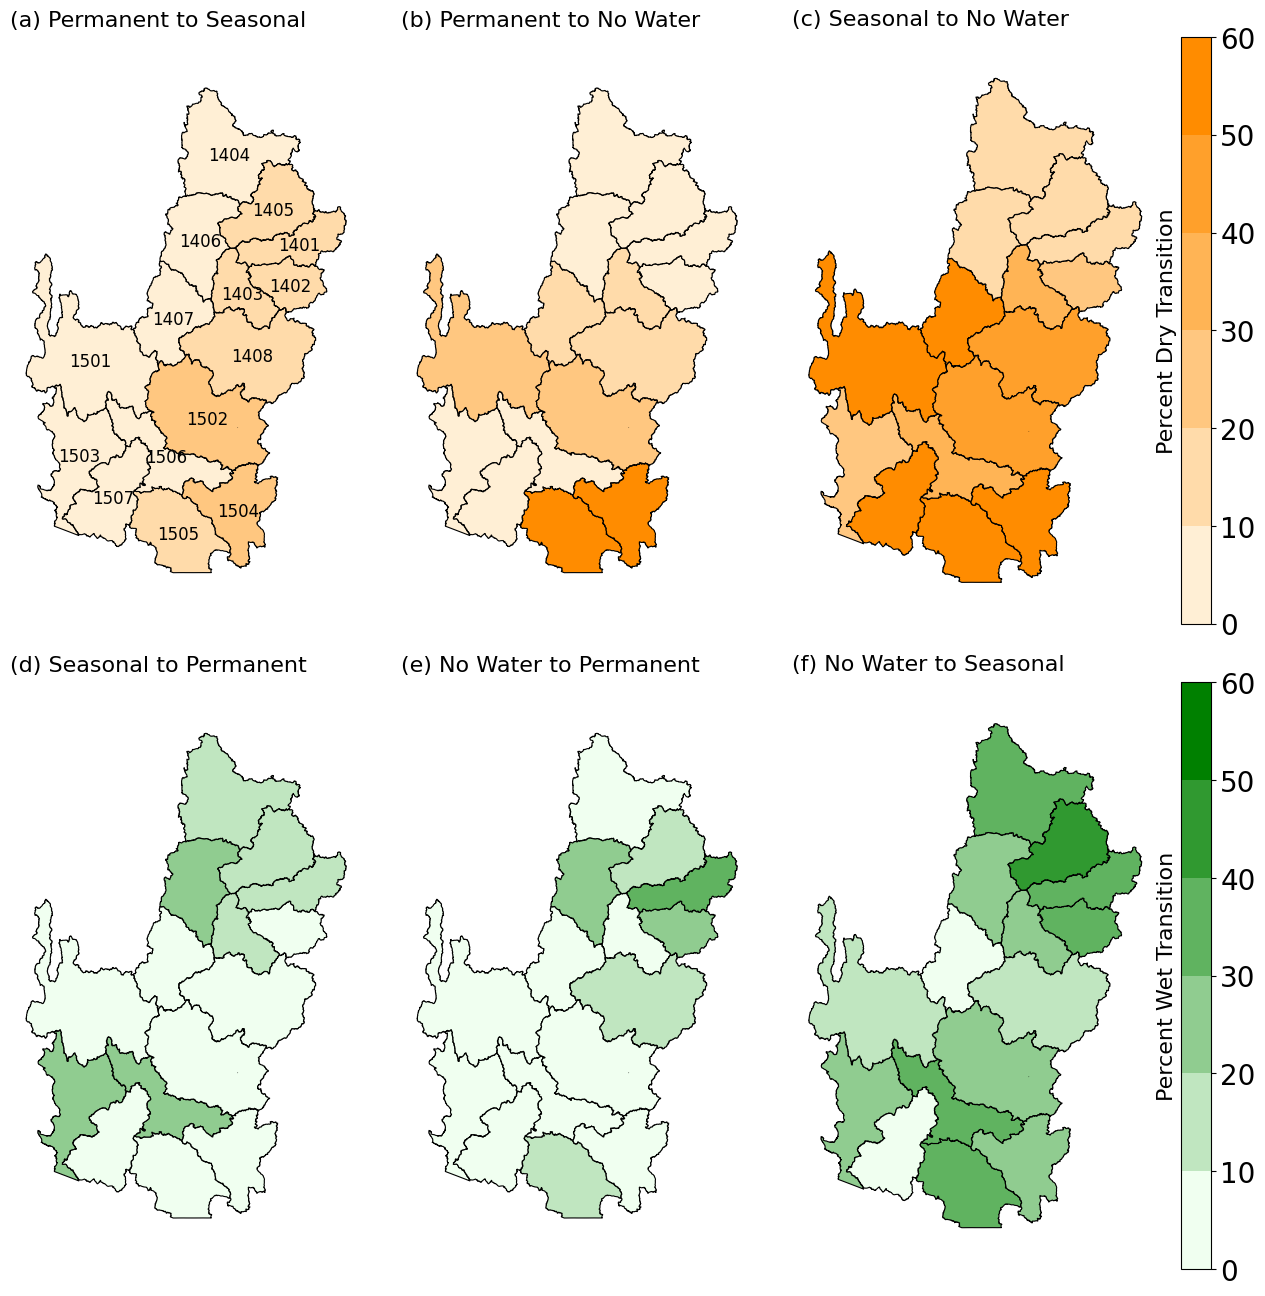

In [11]:
# Define a custom colormap
cmap_dry = mcolors.LinearSegmentedColormap.from_list('custom_dry', [(0, 'papayawhip'),  (1, 'darkorange')], N = 6)
cmap_wet = mcolors.LinearSegmentedColormap.from_list('custom_wet', [(0, 'honeydew'),  (1, 'green')], N = 6)

fig, ax = plt.subplots(2, 3, figsize=(16, 16), gridspec_kw={'width_ratios': [1,1, 1.3]})
plt.rcParams.update({'font.size': 20})
vmin = 0; vmax = 60

huc4_transitions_92_19.plot(ax=ax[0,0], column='perm_season_perc', legend=False, cmap=cmap_dry, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[0,0].axis('off')  # Turn off axis
ax[0,0].text(0, 1.07, '(a) Permanent to Seasonal', transform=ax[0,0].transAxes, fontsize = 16)

huc4_transitions_92_19.plot(ax=ax[0,1], column='perm_nowater_perc', legend=False, cmap=cmap_dry, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[0,1].axis('off')  # Turn off axis
ax[0,1].text(0, 1.07, '(b) Permanent to No Water', transform=ax[0,1].transAxes, fontsize = 16)

huc4_transitions_92_19.plot(ax=ax[0,2], column='seasonal_nowater_perc', legend=True, cmap=cmap_dry, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[0,2].axis('off')  # Turn off axis
ax[0,2].text(0, 1.05, '(c) Seasonal to No Water', transform=ax[0,2].transAxes, fontsize = 16)
ax[0,2].text(1.05,0.5, 'Percent Dry Transition',horizontalalignment='right',
        verticalalignment='center', rotation='vertical', transform=ax[0,2].transAxes, fontsize = 16)

huc4_transitions_92_19.plot(ax=ax[1,0], column='seasonal_perm_perc', legend=False, cmap=cmap_wet, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[1,0].axis('off')  # Turn off axis
ax[1,0].text(0, 1.07, '(d) Seasonal to Permanent', transform=ax[1,0].transAxes, fontsize = 16)

huc4_transitions_92_19.plot(ax=ax[1,1], column='nowater_perm_perc', legend=False, cmap=cmap_wet, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[1,1].axis('off')  # Turn off axis
ax[1,1].text(0, 1.07, '(e) No Water to Permanent', transform=ax[1,1].transAxes, fontsize = 16)

huc4_transitions_92_19.plot(ax=ax[1,2], column='nowater_season_perc', legend=True, cmap=cmap_wet, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[1,2].axis('off')  # Turn off axis
ax[1,2].text(0, 1.05, '(f) No Water to Seasonal', transform=ax[1,2].transAxes, fontsize = 16)
ax[1,2].text(1.05,0.5, 'Percent Wet Transition',horizontalalignment='right',
        verticalalignment='center', rotation='vertical', transform=ax[1,2].transAxes, fontsize = 16)


for idx, row in huc4_transitions_92_19.iterrows():
    ax[0,0].text(row.geometry.centroid.x - 0.6, row.geometry.centroid.y - 0.2, 
               row["huc4"], fontsize=12, color='black')

plt.subplots_adjust(wspace=0.1, hspace=0.1) 

plt.savefig('../Results/figures/transition_percent_change-figure3.jpg', bbox_inches ='tight', dpi = 600)

## Annualized dry and wet transitions 
These are calcualted from the wet period to the end of study period and from severe drought period to end of study period. 

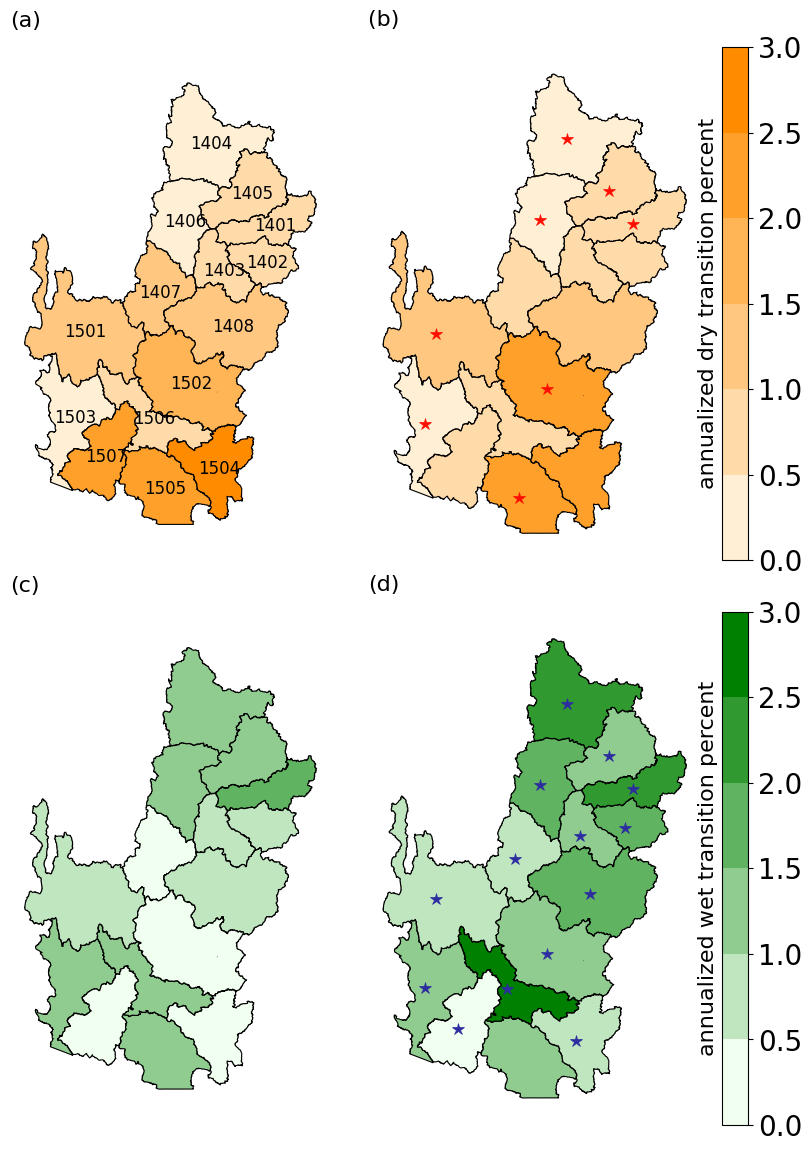

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(10, 14), gridspec_kw={'width_ratios': [1, 1.3]})
plt.rcParams.update({'font.size': 20})

# Define a custom colormap
cmap_dry = mcolors.LinearSegmentedColormap.from_list('custom_dry', [(0, 'papayawhip'),  (1, 'darkorange')], N = 6)
cmap_wet = mcolors.LinearSegmentedColormap.from_list('custom_wet', [(0, 'honeydew'),  (1, 'green')], N = 6)

#limit the color bar 
vmin = 0
vmax = 3

huc4_transitions_92_19.plot(ax=ax[0,0], column='dry_trans_area_perc', legend=False, cmap=cmap_dry, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[0,0].axis('off')  # Turn off axis
ax[0,0].text(0, 1.07, '(a)', transform=ax[0,0].transAxes, fontsize = 16)

huc4_transitions_02_19.plot(ax=ax[0,1], column='dry_trans_area_perc', legend=True, cmap=cmap_dry, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[0,1].axis('off')  # Turn off axis
ax[0,1].text(0, 1.05, '(b) ', transform=ax[0,1].transAxes, fontsize = 16)
ax[0,1].text(1.05,0.5, 'annualized dry transition percent',horizontalalignment='right',
        verticalalignment='center', rotation='vertical', transform=ax[0,1].transAxes, fontsize = 16)

huc4_transitions_92_19.plot(ax=ax[1,0], column='wet_trans_area_perc', legend=False, cmap=cmap_wet, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[1,0].axis('off')  # Turn off axis
ax[1,0].text(0, 1.07, '(c)', transform=ax[1,0].transAxes, fontsize = 16)

huc4_transitions_02_19.plot(ax=ax[1,1], column='wet_trans_area_perc', legend=True, cmap=cmap_wet, linewidth=0.8, edgecolor='0', vmin=vmin, vmax=vmax)
ax[1,1].axis('off')  # Turn off axis
ax[1,1].text(0, 1.05, '(d)', transform=ax[1,1].transAxes, fontsize = 16)
ax[1,1].text(1.05,0.5, 'annualized wet transition percent',horizontalalignment='right',
        verticalalignment='center', rotation='vertical', transform=ax[1,1].transAxes, fontsize = 16)

#add HUC labels to sub-figure (a) 
for idx, row in huc4_transitions_92_19.iterrows():
    ax[0,0].text(row.geometry.centroid.x - 0.6, row.geometry.centroid.y - 0.2, 
               row["huc4"], fontsize=12, color='black')
    
# Add star labels for dry transitions in sub-figure (b) 
for idx, row in huc4_transitions_02_19.iterrows():
    huc4 = row['huc4']
    dry_92 = huc4_transitions_92_19.loc[huc4_transitions_92_19['huc4'] == huc4, 'dry_trans_area_perc'].values[0]
    if row['dry_trans_area_perc'] > dry_92:
        ax[0, 1].plot(row.geometry.centroid.x - 0.2, row.geometry.centroid.y - 0.1,  marker = '*', markersize=9, color='#ff0d00',markeredgewidth=0.5)

# Add star labels for wet transitions
for idx, row in huc4_transitions_02_19.iterrows():
    huc4 = row['huc4']
    wet_92 = huc4_transitions_92_19.loc[huc4_transitions_92_19['huc4'] == huc4, 'wet_trans_area_perc'].values[0]
    if row['wet_trans_area_perc'] > wet_92:
        ax[1, 1].plot(row.geometry.centroid.x-0.2, row.geometry.centroid.y-0.1, marker = '*', markersize = 9 , color='#2c2ca0', markeredgewidth = 0.5)


plt.subplots_adjust(wspace=0.1, hspace=0.1) 
plt.savefig('../Results/figures/annualized_wet_dry_transitions-figure5.jpg', bbox_inches ='tight', dpi = 600)

## Relative importance of try and wet transitions happening in urban areas. 
This is looking at the total dry and wet transitions that happened in each huc from 1994 to 2021, and the percent of these transitions occuring in urban areas. The blue dash line shows the percent of urbanization in the respective huc. 

In [ ]:
transition_urban = pd.read_csv('../Data/analysis-data/transitions_urbanization_92_19.csv')
transition_urban.columns

Index(['huc4', 'HUC_count', 'gained_urban_area', 'stable_urban_area',
       'dry_transition_area', 'wet_transition_area', 'stable_urban_dry_area',
       'gained_urban_dry_area', 'stable_urban_wet_area',
       'gained_urban_wet_area', 'urbanization_percent',
       'stable-urban_dry_perc', 'gained-urban_dry_perc',
       'stable-urban_wet_perc', 'gained-urban_wet_perc', 'urban_dry_perc',
       'urban_wet_perc'],
      dtype='object')

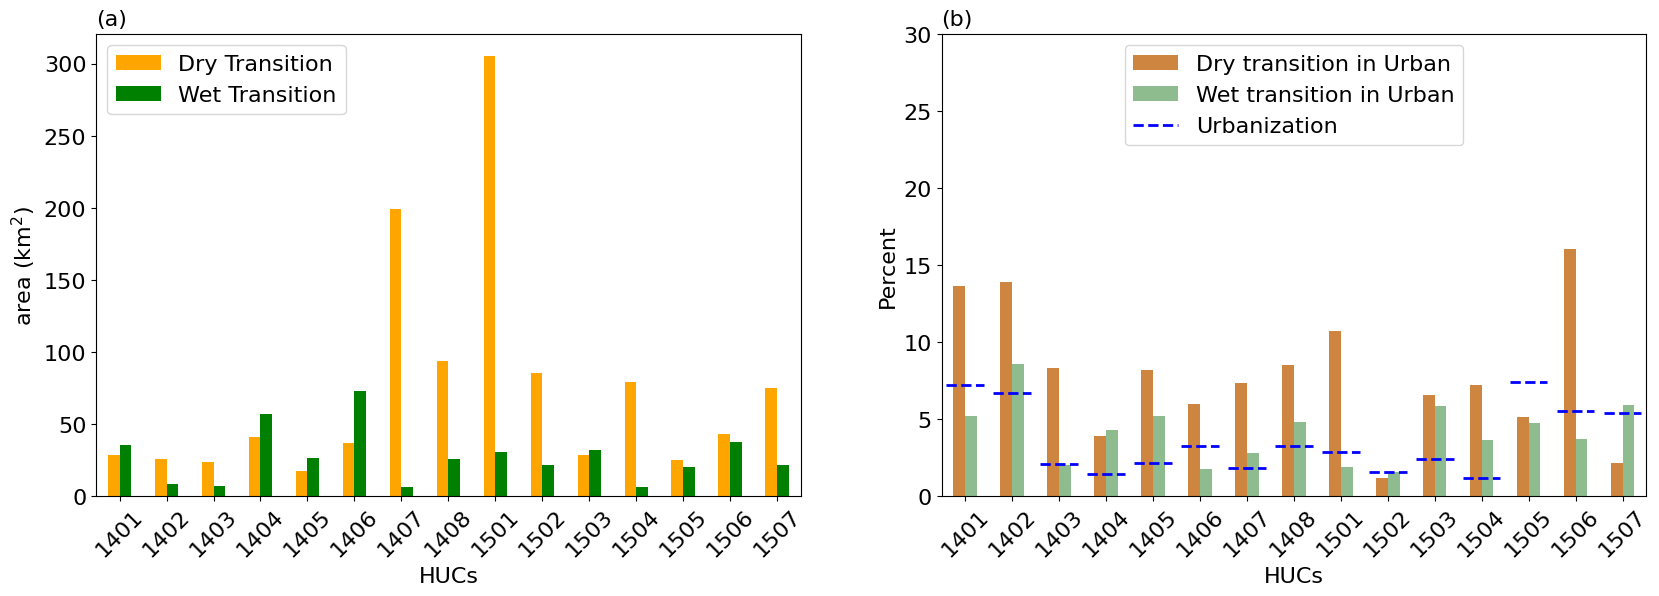

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plt.rcParams.update({'font.size': 16})
color = ['peru', 'darkseagreen']
#get the dry and wet transition for each type
transition_urban.plot.bar(ax = ax[0], x = 'huc4', y = ['dry_transition_area', 'wet_transition_area'], color = ['orange', 'green'])
ax[0].set_ylabel('area (km$^2$)', fontsize = 16)
ax[0].set_xlabel('HUCs', fontsize = 16)
ax[0].text(0, 1.02, '(a)', transform=ax[0].transAxes, fontsize = 16)
ax[0].tick_params(axis='x', labelrotation=45)  # Rotate x labels
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=16)

h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h[:2],["Dry Transition", "Wet Transition"], loc=2, fontsize=16)

transition_urban.plot.bar(ax = ax[1], x = 'huc4', y = ['urban_dry_perc', 'urban_wet_perc'], color = color, stacked = False)
ax[1].text(0, 1.02, '(b)', transform=ax[1].transAxes, fontsize = 16)
ax[1].set_xlabel('HUCs', fontsize = 16)
ax[1].set_ylabel('Percent', fontsize = 16)
ax[1].set_ylim(0, 30)
ax[1].tick_params(axis='x', labelrotation=45)  # Rotate x labels
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=16)

for i, huc in enumerate(transition_urban['huc4']):
    fraction_value = transition_urban.loc[i, 'urbanization_percent']  # Adjust if fraction_urban is a column in your DataFrame
    #bar = ax[1].patches[i]  # Get the i-th bar
    ax[1].hlines(
        y=fraction_value,
        xmin= i - 0.4,
        xmax= i + 0.4 ,
        color='blue', linestyles='--', linewidth=2
    )

# Create a custom legend for the fraction_urban line
custom_line = Line2D([0], [0], color='blue', linestyle='--', linewidth=2)

# Add the custom legend to the plot
#ax[1].legend([custom_line], ['Urban fraction'], loc='upper right')  

h1,l1 = ax[1].get_legend_handles_labels()
ax[1].legend(h1 + [custom_line], ['Dry transition in Urban','Wet transition in Urban', 'Urbanization'], loc='upper center', fontsize=16)

plt.savefig('../Results/figures/transitions_urban_areas-figure6.jpg', bbox_inches ='tight', dpi = 600)